# Photonic Crystal Hamiltonian Inference
###       Final Project, Group 5, PHYS201, Harvard University, Spring 2023
####      Group Members: Thi Huong Thao Dinh, Fan Du, Yiting Huang

In [2]:
#import the package 
import inference



## Background
Photonic crystals (PhC) are micro/nano artificial atoms composed of periodically perturbed refractive indices dielectric material, which can manipulate the propagation of electromagnetic (EM) waves in a similar manner to how actual crystals manipulate electron waves. The periodic symmetry and Maxwell equations guarantee that the eigenmodes of EM waves can be held in PhC are represented by photonic band structures. One popular method to analyze the band structures of photonic crystals is to apply the Hamiltonian formalism, however, the method to select Hamiltonian basis has been left unrevealed in the majority of related papers. This will be the main purpose of our project.

## Generative Model: The Hamiltonian Matrix
The Hamiltonian matrix consists of coupling parameters that describe the interaction between different Bloch waves in the basis. At each value of $(k_x,k_y)$, the energy levels can be obtained by diagonalizing the Hamiltonian matrix and finding its eigenvalues. Due to the C4 symmetry of our square lattice, the allowed basis sizes are 5, 9, 13,... We will perform model comparison to infer what basis size yields the best fit to our measured data.

We start with a model that consists of 4 atoms surrounding the $\Gamma$ point in $k-$space, whoses inteaction can be described by 5 coupling parameters:

![title](./reference_img/5-basis-doodle.png)

Where $U_{10},U_{11}$ and $U_{20}$ represent coupling between atoms of different distances, $\epsilon_0$ being the energy level at the $\Gamma$ point, and $\epsilon$ being the energy level of other atoms. Let $P_1$ be the $\Gamma$ point, $P_2,P_3,P_4,P_5$ be the 4 points surrounding it by a clock-wise order starting at the point below the $\Gamma$ point. If we describe the model in the basis of $\{ P_1,P_2,P_3,P_4,P_5\}$, then the corresponding Hamiltonian matrix is:
$$ H =  \begin{pmatrix} \epsilon_0 & U_{10}& U_{10}& U_{10}& U_{10} \\ U_{10}& \epsilon & U_{11}& U_{20}& U_{11} \\ U_{10}& U_{11}& \epsilon & U_{11}& U_{20} \\ U_{10}& U_{20}&U_{11}& \epsilon & U_{11}\\ U_{10}& U_{11}&U_{20}& U_{11}  & \epsilon  \end{pmatrix}$$

The matrix is inherently diagonalizable and has the eigenvalues $\{ e_1,e_2,e_3,e_4,e_5\}$. 

($\textit{Data tells us that two of these eigenvlaues are always equal, we do not know why right now.}$) 

### Multiple Lorentzian Peak Model (at the particular point $\Gamma$ )

Our model is a multiple Lorentzian peak model where the peak positions are equal to $\{ e_1,e_2,e_3,e_4,e_5\}$ and the widths are equal to nuisance parameters that we will marginalize over. The statistical model can be described as 

$$ 
e_i \sim \text{Uniform} \,(e_{i,min},e_{i,max}) \\
\gamma \sim \text{Uniform} \,(c_{min},c_{max})\\ 
M = \sum_i \text{Lorentzian} \, (e_i, \gamma) $$ 

where $e_{i,min},e_{i,max}, c_{min},c_{max}$ are constants calculated sampled based on the raw data.







## Building Up the Minimal Generative Model



In [3]:
#import the conventional packages for PYMC inference
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import pandas as pd
import pymc as pm
import scipy.signal as sg
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
from matplotlib import rcParams
# import pytesseract as pt
import seaborn as sns
import matplotlib.patches as patches
import matplotlib.gridspec as gs
import math
from importlib import reload
from PIL import Image
import matplotlib as mpl
#import tifffile
from matplotlib.font_manager import FontProperties
from scipy import interpolate 
import pylab as pl  
import seaborn as sns
from pprint import pprint
from numpy import cos, sin, tan, sqrt
from matplotlib.colors import LogNorm
#from tqdm import tqdm
from scipy.optimize import fsolve
from math import sin,cos,e, sqrt
from scipy.optimize import least_squares

### Step 1: Defining the Hamiltonian Matrix

In the following codeblock, we will define a 4 dimension coordinate system to account for the 4 points in k-space unit-cell centered at the $\Gamma$ point: $(1,0,0,0), (0,1,0,0), (0,0,1,0)$ and $(0,0,0,1)$. The $\Gamma$ point itself is $(0,0,0,0)$.

In [4]:
# H functions
DEG = np.pi/180

class coor: ### each point represents a neighbor of the Gamma point
    def __init__(self, i,j,k,l):
        self.i, self.j, self.k, self.l = i,j,k,l
        self.x = self.i + self.k - self.l
        self.y = self.j + self.l + self.k
    def __repr__(self):
        return f'({self.i},{self.j},{self.k},{self.l})'
    def __eq__(self, other):
        if (self.i == other.i) and (self.j == other.j) and (self.k == other.k) and (self.l == other.l):
            return True
        else:
            return False
    def __add__(self, o):
        return coor(self.i+o.i, self.j+o.j, self.k+o.k, self.l+o.l)
    def __sub__(self, o):
        return coor(self.i-o.i, self.j-o.j, self.k-o.k, self.l-o.l)
    def __mul__(self, o):
        return coor(self.i*o, self.j*o, self.k*o, self.l*o)
    def __neg__(self):
        return coor(-self.i,- self.j, -self.k, -self.l)
    def __abs__(self):
        return coor(abs(self.i), abs(self.j), abs(self.k), abs(self.l))
        
class coors: ### list of coors
    def __init__(self, coors):
        self.coors = coors
    def __repr__(self):
        return ';'.join([f'({coor.i},{coor.j},{coor.k},{coor.l})' for coor in self.coors])
    def __add__(self, o):
        res = [i+j for i in self.coors for j in o.coors]
        return coors(uniques(res))
    def __sub__(self, o):
        res = [i-j for i in self.coors for j in o.coors]
        return coors(uniques(res))
    def visualize(self, marker='*', color='blue', size=50, alpha=1.0):
        for coor in self.coors:
            x = coor.i + coor.k - coor.l
            y = coor.j + coor.l+ coor.k
            plt.scatter([x],[y],marker=marker, color=color, s=size, alpha=alpha)
            
def uniques(test_list): ### remove duplicates in a list of coors
    res = []
    [res.append(x) for x in test_list if x not in res]
    return res


def slabmode(kx, ky, neff=1.573, ratio=0.3): ### The authentic waveguide mode, TM0 mode
    ###ratio = thickness/lattice constant
    k=np.sqrt(kx**2+ky**2)
    def func(k0):
        return neff**2*np.sqrt( k**2-k0**2 ) -  np.sqrt( (neff**2)*(k0)**2-k**2 ) * np.tan(np.sqrt( (neff**2)*(k0)**2-k**2 )*2*np.pi*ratio)
#     result = fsolve(func, k/neff+0.1)
    
    res = least_squares(func, (k/neff+0.000001), bounds = (k/neff,k))
    return res.x[0]


alpha = 0 ### I DONT KNOW WHAT IS ALPHA SO I HAVE TO MAKE IT ZERO
# Based on the given coordinate system, defining the Hamiltonian matrix.
# h11, v11 and u20 are coupling parameters. neff is the energy of the 4 neighbors of the Gamma point
# What is ratio? I DONT KNOW

def ham1(theta):
    h11, v11, u20, neff, ratio = theta 
    kx = 0.05
    ky = 0.0
    ham = np.zeros([Nbases,Nbases],dtype=float) ### potentially complex, if want gain and loss
    ### diagonal freqs
    for i in range(Nbases):
        Gx, Gy = Gbases.coors[i].x, Gbases.coors[i].y
        kxinc=kx-Gx*sin(alpha/2)+Gy*sin(alpha/2) ###QUESTION: WHAT IS ALPHA?
        kyinc=ky-Gx*cos(alpha/2)-Gy*cos(alpha/2)
        ham[i,i] = slabmode(kxinc,kyinc,neff,ratio)
    ### off-diagonal coupling

    criteria_h11 = [G1x-G1y,-G1x+G1y]
    criteria_v11 = [G1x+G1y,-G1x-G1y]
    criteria_u20 = [G1x*2,G1y*2]
    
    #### fill in the entries
    for i in range(Nbases):
        for j in range(i+1,Nbases):
            G1 = Gbases.coors[i]
            G2 = Gbases.coors[j]   

            if abs(G2-G1) in criteria_u20:
                # print(U20)
                ham[i,j] = u20
                ham[j,i] = u20
                continue

            if (G2-G1) in criteria_h11:
                # print(U10)
                ham[i,j] = h11
                ham[j,i] = h11
                continue

            if (G2-G1) in criteria_v11:
                # print(U10)
                ham[i,j] = v11
                ham[j,i] = v11
                continue
    eigs = np.linalg.eigvals(ham)
    Cn=np.real(eigs)
    return Cn



Origin = coor(0,0,0,0)
G1x = coor(1,0,0,0)
G1y = coor(0,1,0,0)
G2x = coor(0,0,1,0)
G2y = coor(0,0,0,1)
# G1s = coors([G1x, -G1x, G1y, -G1y])
G1s = coors([G1y, G1x, -G1y, -G1x])

Gbases = coors(uniques(G1s.coors))
Nbases = len(Gbases.coors) ### num of bases
 

### Step 2: Generating a small test data set based on the generative model
From the previous codeblock, we have a method of generating the eigenvalues of the Hamiltonian based on 5 parameters. These eigenvalues will be the peak position in our multiple Lorentzian Peak Model. For the following codeblock, we will generate a small test data set based on the model. To fulfill the minimal goal as of now, we will set the width parameter $\gamma$ of the Lorentzian from a uniform prior distribution.


In [42]:
n = 4 # fit 4 peaks
from pytensor import tensor as pt
with pm.Model() as test_model:
    #Define some coupling parameters
    h11 = 0.006
    v11=  0.004
    u20 = 0.0025
    neff=  2.1
    ratio = 0.3
    #generate the list of eigenvalues based on these given parameters
    theta1=pt.as_tensor_variable(ham1([h11, v11, u20, neff, ratio]))
    theta2 = ham1([h11, v11, u20, neff, ratio])
    print(theta2)
  
    # the Lorentzian width is drawn from a uniform prior
    sigma_L = pm.Uniform('peak_width', 0.001,0.01)

    components = pm.Cauchy.dist(alpha=pm.math.stack(theta2,shape=4),beta =sigma_L)
    # for theta in thetas:
    #     print(theta)
    #     peaks.append(pm.Cauchy.dist(alpha=theta, beta=sigma_L))
    # print(peaks)


    w = pm.Dirichlet('w', a=np.ones_like(np.arange(4)))
    line = pm.Mixture('line', w = w,  comp_dists = components) #spectral line model






[0.60165458 0.58865458 0.58165458 0.58465458]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [peak_width, w, line]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 25 seconds.


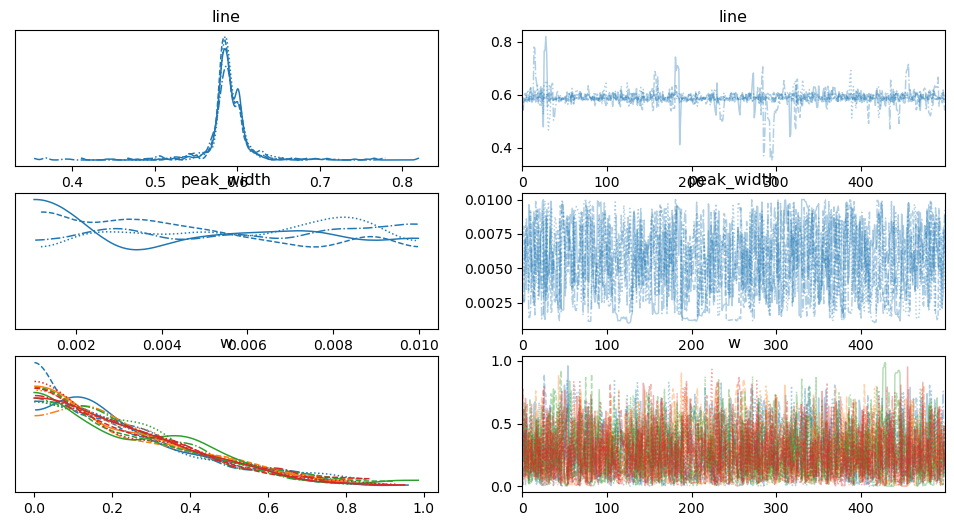

In [43]:
import arviz as az
with test_model:
    idata = pm.sample(500)
    az.plot_trace(idata)


## Documentation version using our package

In [9]:
from inference import Model, io

In [12]:
#load the data file into a DataArray
data = io('expdata_GM0.05.npy')

NameError: name 'io' is not defined

In [13]:
prior_bounds = {'h11':[0.003, 0.01], 'u20':[-1e-3, 1e-3], 'A0':[0, 1.2], 'A1':[0.5, 2.5],'A2':[0.5, 2.5], 'A3':[0.5, 2.5], 'A4':[0.5, 2,5], 'peak_width':[0.0005, 0.01]}
ham_model = Model(data,prior_bounds)

NameError: name 'data' is not defined

In [14]:
with ham_model:
    idata = pm.sample(draws=1000, tune=10)
az.plot_trace(idata)

NameError: name 'ham_model' is not defined